In [348]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import jax
import jax.numpy as jnp
import numpy as np
import torch
from jax import random, grad, vmap, jit, hessian, value_and_grad
from jax.experimental import optimizers
from jax.experimental.optimizers import adam, exponential_decay
from jax.experimental.ode import odeint
from jax.nn import relu, elu, softplus
from jax.config import config
# from jax.ops import index_update, index
from jax import lax
from jax.lax import while_loop, scan, cond
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy
import scipy.io
from scipy.io import loadmat

import sys
sys.path.append('../DeepONetsPI/')  # add the pde package to the python path

from layers import MLP, modified_MLP, FF_MLP

from model import DeepONetPI
from utils import RBF
from DataGenerator import DataGenerator, DataGeneratorEfficient
import h5py


# Burgers Equation
$$
\partial_t s + \partial _{x} \left(\frac{s^2}{2} \right) + \partial_y \left( \frac{s^2}{2} \right) = \nu \left( \partial_{xx} s + \partial_{yy} s \right), \quad x \in(0,1), y\in(0,1), t \in(0,1], \\
s(x, y, 0) = u(x, y), \\
s(0, y, t) = s(1, y, t),  \\
s(x, 0, t) = s(x, 1, t),\\
\partial_x s(0, y, t) = \partial_x s(1, y, t), \partial_y s(0, y, t) = \partial_y s(1, y, t) \\
\partial_x s(x, 0, t) = \partial_x s(x, 1, t), \partial_y s(x, 0, t) = \partial_y s(x, 1, t) \\
\nu = 0.0
$$


In [349]:
def f(x, y):
    res = 2.0*x**2 - 3.0*y
    return res

x = 1.0
y = 2.0
f(x, y)

f2_ = lambda x, y: f(x, y)**2
def f2(x, y):
    res = f(x, y)**2
    return res
fx = grad(f, 0)(x, y)
fy = grad(f, 1)(x, y)
f2x = grad(f2_, 0)(x, y)
f2y = grad(f2_, (0, 1))(x, y)
display(fx)
display(fy)
display(f2x)
display(f2y)

DeviceArray(4., dtype=float32)

DeviceArray(-3., dtype=float32)

DeviceArray(-32., dtype=float32)

(DeviceArray(-32., dtype=float32), DeviceArray(24., dtype=float32))

# Define the Model

In [350]:
class Burgers2dDeepONetPI(DeepONetPI):
    def __init__(self,
                 branch_layers, 
                 trunk_layers, 
                 branch_net=MLP,
                 trunk_net=MLP,
                 branch_activation=jnp.tanh,
                 trunk_activation=jnp.tanh,
                 branch_rng_key=random.PRNGKey(1234),
                 trunk_rng_key=random.PRNGKey(4321),
                 optimizer=adam(exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9)),
                 operator_loss_const=1.0,
                 physics_loss_const=1.0,
                 bcs_loss_const=1.0,
                 ics_loss_const=1.0,
                 ckpt_dir='Burger',
                 ckpt_file='params.npy',
                 loss_file='loss.npy',
                 loss_operator_file='loss_operator.npy',
                 loss_physics_file='loss_physics.npy',
                 loss_bcs_file='loss_bcs.npy',
                 loss_ics_file='loss_ics.npy',   
                 ):
        super().__init__(branch_layers, 
                         trunk_layers, 
                         branch_net, 
                         trunk_net, 
                         branch_activation, 
                         trunk_activation, 
                         branch_rng_key, 
                         trunk_rng_key, 
                         optimizer, 
                         operator_loss_const, 
                         physics_loss_const, 
                         bcs_loss_const, 
                         ics_loss_const, 
                         ckpt_dir, 
                         ckpt_file, 
                         loss_file, 
                         loss_operator_file, 
                         loss_physics_file, 
                         loss_bcs_file, 
                         loss_ics_file)
#         display(self.dim)
        
    def pde_net(self, params, u, y):
        # note that y here can include additional coord not passed to the original operator network
        # print(y.shape)
        x1 = y[0]
        x2 = y[1]
        t = y[2]
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, x1, x2, t) # actual value of s (may not be needed)
        s2_ = lambda params, u, x1, x2, t: s_(params, u, x1, x2, t)**2

        s_x = grad(s_, 2)(params, u, x1, x2, t)
        s_y = grad(s_, 3)(params, u, x1, x2, t)
        s_t = grad(s_, 4)(params, u, x1, x2, t)
    #     s_xx = grad(grad(s_, 2), 2)(params, u, x1, x2, t)
    #     s_yy = grad(grad(s_, 2), 2)(params, u, x1, x2, t)
    #     s2_x = grad(s2_, 2)(params, u, x1, x2, t)
    #     s2_y = grad(s2_, 3)(params, u, x1, x2, t)
    #     res = s_t + s * s_x - 0.0 * (s_xx +s_yy) # this is equal to u(x), this avoids the interpolation
    #     res = s_t + 0.5 * (s2_x + s2_y)
        res = s_t + s*s_x + s*s_y
        return res
    
    # here we are provided with values for BC/IC (zero), so for this case just call the operator net.  If we had Robin BC for example, we would output an array with outputs of [value, derivative]
    # Also, if we had the case where BC/IC = u, we would return res = s - u
    def bc_net_periodic(self, params, u, y):
#     def bc_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        # s = s_(params, u, y) # actual value of s
        # bc1 is at x1 = 0, bc2 is at x1 = 1, bc3 is at x2 = 0, bc4 is at x2 = 1
        dim = self.dim # shorthand for number of dimensions
#         display(y)
        y_bc1 = y[0:dim]
        y_bc2 = y[dim:2*dim]
        y_bc3 = y[2*dim:3*dim]
        y_bc4 = y[3*dim:]
        x1_bc1, x2_bc1, t_bc1 = y_bc1[0], y_bc1[1], y_bc1[2]
        x1_bc2, x2_bc2, t_bc2 = y_bc2[0], y_bc2[1], y_bc2[2]
        x1_bc3, x2_bc3, t_bc3 = y_bc3[0], y_bc3[1], y_bc3[2]
        x1_bc4, x2_bc4, t_bc4 = y_bc4[0], y_bc4[1], y_bc4[2]
        # display(value_and_grad(s_, (2, 3))(params, u, x1_bc1, x2_bc1, t_bc1))        
#         display(y_bc1)
#         display(y_bc2)
#         display(y_bc3)
#         display(y_bc4)
        s_bc1, (s_x_bc1, s_y_bc1) = value_and_grad(s_, (2, 3))(params, u, x1_bc1, x2_bc1, t_bc1)
        s_bc2, (s_x_bc2, s_y_bc2) = value_and_grad(s_, (2, 3))(params, u, x1_bc2, x2_bc2, t_bc2)
        s_bc3, (s_x_bc3, s_y_bc3) = value_and_grad(s_, (2, 3))(params, u, x1_bc3, x2_bc3, t_bc3)
        s_bc4, (s_x_bc4, s_y_bc4) = value_and_grad(s_, (2, 3))(params, u, x1_bc4, x2_bc4, t_bc4)
        res1_s = jnp.mean((s_bc1 - s_bc2)**2)
        res2_s = jnp.mean((s_bc3 - s_bc4)**2)
        res1_s_x = jnp.mean((s_x_bc1 - s_x_bc2)**2)
        res2_s_x = jnp.mean((s_x_bc3 - s_x_bc4)**2)
        res1_s_y = jnp.mean((s_y_bc1 - s_y_bc2)**2)
        res2_s_y = jnp.mean((s_y_bc3 - s_y_bc4)**2)
        # combine residual
        res = res1_s + res2_s #+ res1_s_x + res2_s_x + res1_s_y + res2_s_y 
#         res = jnp.hstack([res1_s, res2_s, res1_s_x, res2_s_x, res1_s_y, res2_s_y])
#         res = jnp.hstack([res1_s, res2_s, res1_s_x, res2_s_y])
        return res
    

    # here we are provided with values for BC/IC (zero), so for this case just call the operator net.  If we had Robin BC for example, we would output an array with outputs of [value, derivative]
    # Also, if we had the case where BC/IC = u, we would return res = s - u
#     def bc_net_dirichlet(self, params, u, y):
    def bc_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        # s = s_(params, u, y) # actual value of s
        # bc1 is at x1 = 0, bc2 is at x1 = 1, bc3 is at x2 = 0, bc4 is at x2 = 1
        dim = self.dim # shorthand for number of dimensions
#         display(y)
        y_bc1 = y[0:dim]
        y_bc2 = y[dim:2*dim]
        y_bc3 = y[2*dim:3*dim]
        y_bc4 = y[3*dim:]
        x1_bc1, x2_bc1, t_bc1 = y_bc1[0], y_bc1[1], y_bc1[2]
        x1_bc2, x2_bc2, t_bc2 = y_bc2[0], y_bc2[1], y_bc2[2]
        x1_bc3, x2_bc3, t_bc3 = y_bc3[0], y_bc3[1], y_bc3[2]
        x1_bc4, x2_bc4, t_bc4 = y_bc4[0], y_bc4[1], y_bc4[2]
        s_bc1 = s_(params, u, x1_bc1, x2_bc1, t_bc1)
        s_bc2 = s_(params, u, x1_bc2, x2_bc2, t_bc2)
        s_bc3 = s_(params, u, x1_bc3, x2_bc3, t_bc3)
        s_bc4 = s_(params, u, x1_bc4, x2_bc4, t_bc4)
        res = jnp.hstack([s_bc1, s_bc2, s_bc3, s_bc4])
        return res
    
    
    def ic_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, y) # actual value of s
        return s


# Load in the Data

In [351]:
def load_data(files):
#     S = jnp.zeros(())
    file0 = files[0]
    N = len(files)
    # get coordinates and shape
    with h5py.File(file0, 'r') as f0:
        params = f0['params']
#         u0 = jnp.array(params['u0'][:]).reshape((1, -1))
        x1 = jnp.array(params['x'][:]).reshape((-1, 1))
        x2 = jnp.array(params['y'][:]).reshape((-1, 1))
        t = jnp.array(params['times'][:]).reshape((-1, 1))
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
    S = jnp.zeros((N, Nx, Ny, Nt))
    U = jnp.zeros((N, Nx*Ny))
#     Y = jnp.hstack((x1, x2, t))
    Y = (x1, x2, t)
    for i, file in enumerate(files):
        with h5py.File(file, 'r') as f:
            params = f['params']
            u = jnp.array(params['u0'][:]).reshape((-1))
#             display(u)
            s = jnp.array(f['u'][:])
            U = U.at[i, :].set(u)
            S = S.at[i, :].set(s)
    return U, Y, S

In [200]:


# Load data
# data_path = 'Data/Burger.mat'  # Please use the matlab script to generate data

data_files = ['Data/test1.h5']
N_sim = len(data_files)
file_nums = jnp.array(range(N_sim))

data_file0 = data_files[0]


N_train = 1
N_test = N_sim - N_train

with h5py.File(data_file0, 'r') as f:
    params = f['params']
    u = f['u']
    U = jnp.array(params['u0'][:])
    X1 = jnp.array(params['X'][:])
    X2 = jnp.array(params['Y'][:])
    x1 = jnp.array(params['x'][:])
    x2 = jnp.array(params['y'][:])
    t = jnp.array(params['times'][:])
#     S = jnp.array(u[:])
    its = jnp.array(params['iterations'][:])

N = N_sim

Nx = len(x1)
Ny = len(x2)
Nt = len(t)
m = Nx*Ny
N_op = 100000
N_pde = 100000
N_bcs = 100000
N_ics = 10000 # m
# N_ics = None

key = random.PRNGKey(0)
keys = random.split(key, 1)

U, Y, S = load_data(data_files)
dim = len(Y)

In [201]:
display(S[0, ..., 0], U[0].reshape((Nx,Ny)))

DeviceArray([[ 4.82353713e-09,  2.89463088e-07, -1.73249042e-08, ...,
              -5.33573484e-07,  1.44173285e-07,  3.10508383e-08],
             [ 3.96704053e-07, -1.79496668e-02, -8.84183962e-03, ...,
               1.18629046e-01,  1.76086083e-01,  1.16465308e-01],
             [-1.36106181e-07,  2.44664587e-02,  8.57578367e-02, ...,
               2.78149128e-01,  1.83844551e-01,  1.16720192e-01],
             ...,
             [-7.45027648e-08, -6.61870018e-02, -1.30820364e-01, ...,
               1.39566272e-01,  1.55870631e-01,  1.22558571e-01],
             [ 1.86252258e-08, -3.82254645e-02,  1.95328426e-03, ...,
               1.97190166e-01,  2.81451046e-01,  2.01671660e-01],
             [ 5.39195106e-08,  7.78621295e-03,  1.94587726e-02, ...,
               1.68994337e-01,  2.29726538e-01,  1.50365189e-01]],            dtype=float32)

DeviceArray([[ 4.82353713e-09,  2.89463088e-07, -1.73249042e-08, ...,
              -5.33573484e-07,  1.44173285e-07,  3.10508383e-08],
             [ 3.96704053e-07, -1.79496668e-02, -8.84183962e-03, ...,
               1.18629046e-01,  1.76086083e-01,  1.16465308e-01],
             [-1.36106181e-07,  2.44664587e-02,  8.57578367e-02, ...,
               2.78149128e-01,  1.83844551e-01,  1.16720192e-01],
             ...,
             [-7.45027648e-08, -6.61870018e-02, -1.30820364e-01, ...,
               1.39566272e-01,  1.55870631e-01,  1.22558571e-01],
             [ 1.86252258e-08, -3.82254645e-02,  1.95328426e-03, ...,
               1.97190166e-01,  2.81451046e-01,  2.01671660e-01],
             [ 5.39195106e-08,  7.78621295e-03,  1.94587726e-02, ...,
               1.68994337e-01,  2.29726538e-01,  1.50365189e-01]],            dtype=float32)

# Generate the Data

In [202]:
# Geneate operator training data corresponding to one input sample from a single simulation
def generate_one_op_training_data_efficient(key, u, x1, x2, t, s, index, N_op=1000):
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
    idx = random.randint(key, (N_op, 3), 0, jnp.array([Nx, Ny, Nt]))
#     u_op = jnp.tile(u, (N_op, 1))
    u_op = u
    num_op = jnp.tile(index, (N_op, 1))
    y_op = jnp.hstack((x1[idx[:,0]][:, None], x2[idx[:,1]][:, None], t[idx[:,2]][:, None]))
    s_op = s[idx[:,0], idx[:,1], idx[:,2]][:, None]
    return u_op, y_op, s_op, num_op

# Geneate res training data corresponding to one input sample
def generate_one_pde_training_data_efficient(key, u, index, N_pde=1000):

    subkeys = random.split(key, 3)
   
    t_pde = random.uniform(subkeys[0], (N_pde, 1))
    x1_pde = random.uniform(subkeys[1], (N_pde, 1))
    x2_pde = random.uniform(subkeys[2], (N_pde, 1))
#     u_pde = jnp.tile(u, (N_pde, 1))
    u_pde = u
    num_pde = jnp.tile(index, (N_pde, 1))
    y_pde =  jnp.hstack([x1_pde, x2_pde, t_pde])
    s_pde = jnp.zeros((N_pde, 1))
    return u_pde, y_pde, s_pde, num_pde

# Geneate bcs training data corresponding to one input sample
def generate_one_bcs_training_data_efficient(key, u, index, N_bcs=1000):
    keys = random.split(key, 2)
    t_bc = random.uniform(keys[0], (N_bcs, 1))
#     x1_bc = random.uniform(keys[1], (N_bcs, 1))
#     x2_bc = random.uniform(keys[2], (N_bcs, 1))
    x_bc = random.uniform(keys[1], (N_bcs, 1))
    x1_bc1 = jnp.zeros((N_bcs, 1))
    x1_bc2 = jnp.ones((N_bcs, 1))
    x2_bc3 = jnp.zeros((N_bcs, 1))
    x2_bc4 = jnp.ones((N_bcs, 1))
  
    y1 = jnp.hstack([x1_bc1, x_bc, t_bc])  # shape = (N_bcs, 3)
    y2 = jnp.hstack([x1_bc2, x_bc, t_bc])  # shape = (N_bcs, 3)
    y3 = jnp.hstack([x_bc, x2_bc3, t_bc])  # shape = (N_bcs, 3)
    y4 = jnp.hstack([x_bc, x2_bc4, t_bc])  # shape = (N_bcs, 3)
    
    u_bc = u
    num_bc = jnp.tile(index, (N_bcs, 1))
    y_bc =  jnp.hstack([y1, y2, y3, y4])  # shape = (N_bcs, dim*4=12)
    s_bc = jnp.zeros((N_bcs, 4)) # 4 for dichlet
#     s_bc = jnp.zeros((N_bcs, 1)) # 6 for periodic 

    return u_bc, y_bc, s_bc, num_bc

# Geneate ics training data corresponding to one input sample (set to N_ics to None to generate inputs for the entire initial condition)
def generate_one_ics_training_data_efficient(key, u, x1, x2, index, N_ics=None):
    Nx = len(x1)
    Ny = len(x2)
    
    
#     x1 = jnp.linspace(0, 1, N_ics)[:, None]
#     x2 = jnp.linspace(0, 1, N_ics)[:, None]
#     x1 = jnp.linspace(0, 1, N_ics)[:, None]
    if N_ics is None:
        t = jnp.zeros((Nx*Ny, 1))
        X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')
        X1 = X1.reshape((-1, 1))
        X2 = X2.reshape((-1, 1))
        u_ic = jnp.tile(u, (Nx*Ny, 1))
        y_ic = jnp.hstack([X1, X2, t])
        s_ic = u[:, None]
        num_ic = jnp.tile(index, (Nx*Ny, 1))
    else:
        u0 = u.reshape((Nx, Ny))
        t = jnp.zeros((N_ics, 1))
#         X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')
#         X1 = X1.reshape((-1, 1))
#         X2 = X2.reshape((-1, 1))
        idx = random.randint(key, (N_ics, 2), 0, jnp.array([Nx, Ny]))
        y_ic = jnp.hstack([x1[idx[:,0]], x2[idx[:,1]], t])
        u_ic = u
        num_ic = jnp.tile(index, (N_ics, 1))
        s_ic = u0[idx[:,0], idx[:,1]][:, None]
        
#     display(s_ic.shape)

    return u_ic, y_ic, s_ic, num_ic

def generate_one_training_data_efficient(key, u, x1, x2, t, s, index, N_op, N_pde, N_bcs, N_ics):
    # Generate subkeys
    keys = random.split(key, 4)
    u_op, y_op, s_op, num_op = generate_one_op_training_data_efficient(keys[0], u, x1, x2, t, s, index, N_op)
    u_pde, y_pde, s_pde, num_pde = generate_one_pde_training_data_efficient(keys[1], u, index, N_pde)
    u_bcs, y_bcs, s_bcs, num_bcs = generate_one_bcs_training_data_efficient(keys[2], u, index, N_bcs)
    u_ics, y_ics, s_ics, num_ics = generate_one_ics_training_data_efficient(keys[3], u, x1, x2, index, N_ics)

    # Shorthand tuples to pass fewer outputs
    train_op = (u_op, y_op, s_op, num_op)
    train_pde = (u_pde, y_pde, s_pde, num_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs, num_bcs)
    train_ics = (u_ics, y_ics, s_ics, num_ics)
    
    return train_op, train_pde, train_bcs, train_ics

def generate_training_data_efficient(key, U, x1, x2, t, S, N_op, N_pde, N_bcs, N_ics):
    # Get Number of simultions
    N = S.shape[0]
    indices = jnp.arange(N)
    
    # Get simulation dimensions
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
    
    # Generate subkeys
    keys = random.split(key, N)
    
    # Generate training data using vmap
    train_op, train_pde, train_bcs, train_ics = vmap(generate_one_training_data_efficient, (0, 0, None, None, None, 0, 0, None, None, None, None))(keys, U, x1, x2, t, S, indices, N_op, N_pde, N_bcs, N_ics)
    
    if N_ics is None:
        N_ics = Nx*Ny

    u_op, y_op, s_op, num_op = train_op
    u_pde, y_pde, s_pde, num_pde = train_pde
    u_bcs, y_bcs, s_bcs, num_bcs = train_bcs
    u_ics, y_ics, s_ics, num_ics = train_ics

    u_op = u_op.reshape(N,-1)
    y_op = y_op.reshape(N * N_op,-1)
    s_op = s_op.reshape(N * N_op,-1)
    num_op = num_op.reshape(N * N_op, -1)

    u_pde = u_pde.reshape(N,-1)
    y_pde = y_pde.reshape(N * N_pde,-1)
    s_pde = s_pde.reshape(N * N_pde,-1)
    num_pde = num_pde.reshape(N * N_pde, -1)

    u_bcs = u_bcs.reshape(N,-1)
    y_bcs = y_bcs.reshape(N * N_bcs,-1)
    s_bcs = s_bcs.reshape(N * N_bcs,-1)
    num_bcs = num_bcs.reshape(N * N_bcs, -1)

    u_ics = u_ics.reshape(N,-1)
    y_ics = y_ics.reshape(N * N_ics,-1)
    s_ics = s_ics.reshape(N * N_ics,-1)
    num_ics = num_ics.reshape(N * N_ics, -1)
    
    train_op = (u_op, y_op, s_op, num_op)
    train_pde = (u_pde, y_pde, s_pde, num_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs, num_bcs)
    train_ics = (u_ics, y_ics, s_ics, num_ics)


    return train_op, train_pde, train_bcs, train_ics
    
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, u, x1, x2, t, s, tind=0):
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
#     s = S[key]
#     u0 = S[:, 0]

#     t = jnp.linspace(0, 1, Nt)
#     x = jnp.linspace(0, 1, Nx)
    X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')
    X1 = X1.reshape((-1,1))
    X2 = X2.reshape((-1,1))
    T = jnp.ones((Nx*Ny, 1)) * t[tind]
    s_test = s[..., tind].reshape((-1, 1))
    u_test = jnp.tile(U[tind], (Nx*Ny, 1))
    y_test = jnp.hstack([X1, X2, T])
#     print(f"s: {s.shape}") 
#     print(f"u: {u.shape}") 
#     print(f"y: {y.shape}") 
    return u_test, y_test, s_test 

# Geneate training data corresponding to N input sample
def compute_error(key, u, x1, x2, t, s):
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
    u_test, y_test, s_test = generate_one_test_data(key, u, x1, x2, t, s)
    
    u_test = u_test.reshape(Nx*Ny*Nt,-1)  
    y_test = y_test.reshape(Nx*Ny*Nt,-1)
    s_test = s_test.reshape(Nx*Ny*Nt,-1)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error = jnp.linalg.norm(s_test - s_pred) / jnp.linalg.norm(s_test) 
    
    return error  

In [203]:

u_test, y_test, s_test = generate_one_test_data(key, U[0], x1, x2, t, S[0])

In [204]:
s_test

DeviceArray([[ 4.8235371e-09],
             [ 2.8946309e-07],
             [-1.7324904e-08],
             ...,
             [ 1.6899434e-01],
             [ 2.2972654e-01],
             [ 1.5036519e-01]], dtype=float32)

In [205]:
s_test.shape

(10000, 1)

In [206]:
train_op, train_pde, train_bcs, train_ics = generate_training_data_efficient(key, U, x1, x2, t, S, N_op, N_pde, N_bcs, N_ics)

u_op_train, y_op_train, s_op_train, num_op_train = train_op
u_pde_train, y_pde_train, s_pde_train, num_pde_train = train_pde
u_bcs_train, y_bcs_train, s_bcs_train, num_bcs_train = train_bcs
u_ics_train, y_ics_train, s_ics_train, num_ics_train = train_ics

In [207]:
u_op_train

DeviceArray([[ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01]],            dtype=float32)

In [208]:
display(u_ics_train, s_ics_train)

DeviceArray([[ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01]],            dtype=float32)

DeviceArray([[ 0.41244724],
             [-0.34530893],
             [ 0.07519691],
             ...,
             [ 0.07667021],
             [-0.8087207 ],
             [-0.00769435]], dtype=float32)

In [209]:
display(y_ics_train)

DeviceArray([[0.09, 0.36, 0.  ],
             [0.28, 0.91, 0.  ],
             [0.13, 0.04, 0.  ],
             ...,
             [0.86, 0.9 , 0.  ],
             [0.27, 0.51, 0.  ],
             [0.07, 0.92, 0.  ]], dtype=float32)

In [210]:
u_op_train

DeviceArray([[ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01]],            dtype=float32)

In [211]:
# # X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')
# X1 = y_ics_train[:, 0].reshape((Nx, Ny))
# X2 = y_ics_train[:, 1].reshape((Nx, Ny))
# s_ics = s_ics_train.reshape((Nx, Ny))
# plt.figure()
# plt.pcolormesh(X1, X2, s_ics, cmap='jet', vmin=-1, vmax=1, shading='gouraud')
# plt.axis('square')
# _ = plt.show()

In [212]:
# s_ics[0] - s_ics[-1]

# Initialize model

In [343]:
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100] # [m, 50, 50, 50, 50, 50] # 
trunk_layers =  [dim, 100, 100, 100, 100, 100, 100, 100] # [dim, 50, 50, 50, 50, 50] #
model = Burgers2dDeepONetPI(branch_layers, trunk_layers, branch_net=modified_MLP, trunk_net=modified_MLP)

# Create data set

In [331]:
batch_size = 10000
op_dataset = DataGeneratorEfficient(u_op_train, y_op_train, s_op_train, num_op_train, batch_size)
pde_dataset = DataGeneratorEfficient(u_pde_train, y_pde_train, s_pde_train, num_pde_train, batch_size)
bcs_dataset = DataGeneratorEfficient(u_bcs_train, y_bcs_train, s_bcs_train, num_bcs_train, batch_size)
ics_dataset = DataGeneratorEfficient(u_ics_train, y_ics_train, s_ics_train, num_ics_train, batch_size)

# Restore Model Before Retraining

In [344]:
model.restore()
model.restore_history()
# model2 = Burgers2dDeepONetPI(branch_layers, trunk_layers, branch_net=modified_MLP, trunk_net=modified_MLP)

In [324]:
params = model.get_params(model.opt_state)
pde_data = iter(pde_dataset)
pde_batch = next(pde_data)
pde_inputs, pde_outputs = pde_batch
u_pde, y_pde = pde_inputs
# params

In [325]:
u_pde

DeviceArray([[ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01],
             [ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01],
             [ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01],
             ...,
             [ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01],
             [ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01],
             [ 4.8235371e-09,  2.8946309e-07, -1.7324904e-08, ...,
               1.6899434e-01,  2.2972654e-01,  1.5036519e-01]],            dtype=float32)

In [329]:
model2.pde_net(params, u_pde[1], y_pde[1])

DeviceArray(17.596272, dtype=float32)

In [330]:
y_pde[1]

DeviceArray([0.00551057, 0.6149912 , 0.05923605], dtype=float32)

In [333]:
# model.train(operator_dataset=op_dataset, physics_dataset=pde_dataset, bcs_dataset=bcs_dataset, ics_dataset=ics_dataset, nIter=10000, log_freq=10)
# model.train(operator_dataset=op_dataset, physics_dataset=None, bcs_dataset=None, ics_dataset=ics_dataset, nIter=10000, log_freq=10)
model2.train(operator_dataset=op_dataset, physics_dataset=pde_dataset, bcs_dataset=None, ics_dataset=ics_dataset, nIter=10000, log_freq=10)

  8%|▊         | 820/10000 [01:58<22:04,  6.93it/s, loss=0.95637894, loss_operator=0.188778, loss_physics=0.017693585, loss_ics=0.7499074]   


KeyboardInterrupt: 

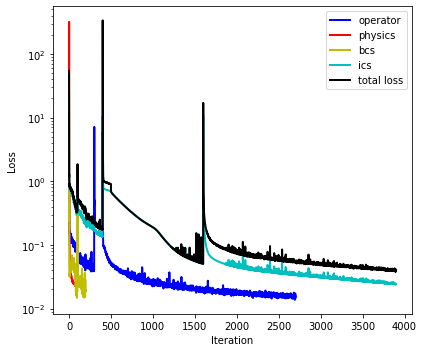

In [290]:
# Plot for loss function

plt.figure(figsize = (6,5))

plt.plot(model.loss_operator_log, 'b-', lw=2, label='operator')
plt.plot(model.loss_physics_log, 'r-', lw=2, label='physics')
plt.plot(model.loss_bcs_log, 'y-', lw=2, label='bcs')
plt.plot(model.loss_ics_log, 'c-', lw=2, label='ics')
plt.plot(model.loss_log, 'k-', lw=2, label='total loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [346]:
# Generate a Single Test Data
# key = 23
# s_test_ = S_test[key]
key = random.PRNGKey(112312347)
# # P_test = 100
# Nx = m
# Nt = 101
tind = 10
u_test, y_test, s_test = generate_one_test_data(key, U[0], x1, x2, t, S[0], tind=tind)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
# x = jnp.linspace(0, 1, Nx)
# t = jnp.linspace(0, 1, Nt)
X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')

# Grid data
# S_pred = griddata(y_test, s_pred.flatten(), (X1,X2), method='cubic')
# S_true = griddata(y_test, s_test.flatten(), (X1,X2), method='cubic')
# S_true = s_test_

S_true = s_test.reshape((Nx, Ny))
S_pred = s_pred.reshape((Nx, Ny))
# compute_error(key, )
# # Compute the relative l2 ermor 
# error = jnp.linalg.norm(S_pred - S_true, 2) / jnp.linalg.norm(S_true, 2) 
# print('Relative l2 errpr: {:.3e}'.format(error))

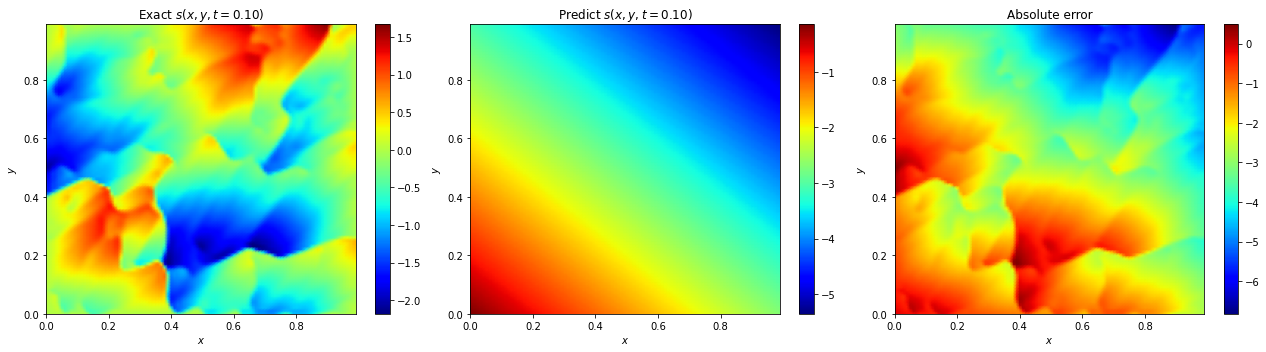

In [347]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $s(x,y,t={float(t[tind]):.2f})$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X1, X2, S_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $s(x,y,t={float(t[tind]):.2f})$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X1, X2, S_pred - S_true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [282]:
S_true[:,0]

DeviceArray([-1.1775099e-01, -1.6102386e-01, -1.5573870e-01,
             -1.5212491e-01, -1.4702260e-01, -1.4226969e-01,
             -1.3913924e-01, -1.4303587e-01, -1.4707401e-01,
             -1.4652383e-01, -1.4970751e-01, -3.5086432e-01,
             -7.6330948e-01, -9.4994324e-01, -9.5119518e-01,
             -9.3028545e-01, -9.3058002e-01, -9.3677568e-01,
             -9.3714213e-01, -9.3699247e-01, -9.3709862e-01,
             -9.3639326e-01, -9.3260020e-01, -9.2574835e-01,
             -9.1706872e-01, -9.0934521e-01, -9.0410060e-01,
             -8.9985192e-01, -8.9409888e-01, -8.8662577e-01,
             -8.7759346e-01, -8.6765808e-01, -8.5826707e-01,
             -8.5196352e-01, -8.5192615e-01, -8.6074877e-01,
             -8.7804919e-01, -8.9700860e-01, -9.1014987e-01,
             -9.1543138e-01, -9.1373748e-01, -9.0799123e-01,
             -9.0104723e-01, -8.9379191e-01, -8.8607931e-01,
             -8.7764722e-01, -8.6867827e-01, -8.5957497e-01,
             -8.5074884e

In [345]:
params = model.get_params(model.opt_state)
model.predict_pde(params, u_test, y_test)

DeviceArray([-2.6551442, -2.4918277, -2.3284929, ..., 19.575266 ,
             19.641369 , 19.70679  ], dtype=float32)

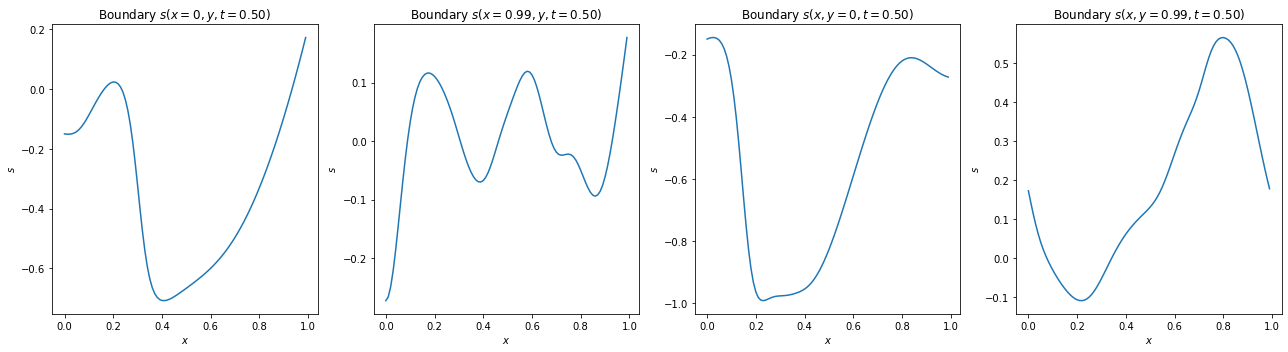

In [287]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.plot(x1, S_pred[0])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x=0,y,t={float(t[tind]):.2f})$')
plt.tight_layout()

plt.subplot(1,4,2)
plt.plot(x1, S_pred[-1])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x=0.99,y,t={float(t[tind]):.2f})$')
plt.tight_layout()

plt.subplot(1,4,3)
plt.plot(x1, S_pred[:,0])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x,y=0,t={float(t[tind]):.2f})$')
plt.tight_layout()


plt.subplot(1,4,4)
plt.plot(x1, S_pred[:,-1])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x,y=0.99,t={float(t[tind]):.2f})$')
plt.tight_layout()




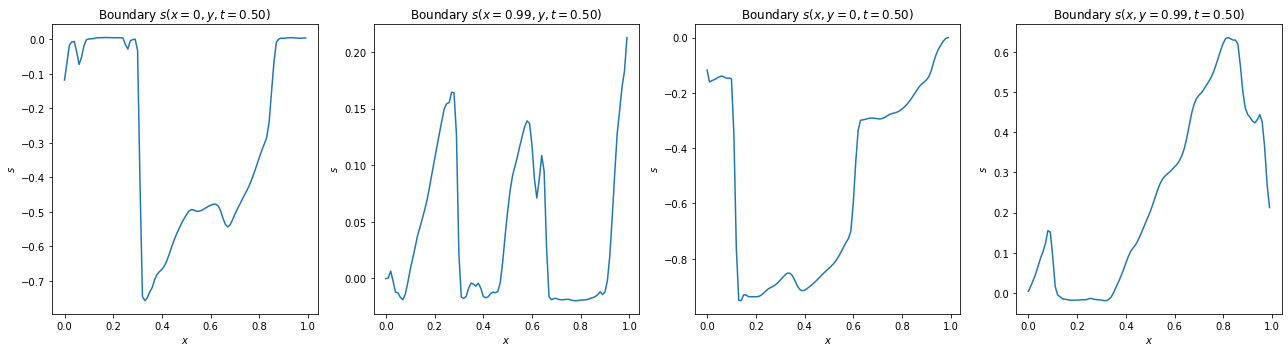

In [288]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.plot(x1, S_true[0])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x=0,y,t={float(t[tind]):.2f})$')
plt.tight_layout()

plt.subplot(1,4,2)
plt.plot(x1, S_true[-1])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x=0.99,y,t={float(t[tind]):.2f})$')
plt.tight_layout()

plt.subplot(1,4,3)
plt.plot(x1, S_true[:,0])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x,y=0,t={float(t[tind]):.2f})$')
plt.tight_layout()


plt.subplot(1,4,4)
plt.plot(x1, S_true[:,-1])
# plt.pcolormesh(X1, X2, S_true, cmap='jet', shading='gouraud')
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.title(f'Boundary $s(x,y=0.99,t={float(t[tind]):.2f})$')
plt.tight_layout()



In [286]:
S_true[:,0]

DeviceArray([-1.1775099e-01, -1.6102386e-01, -1.5573870e-01,
             -1.5212491e-01, -1.4702260e-01, -1.4226969e-01,
             -1.3913924e-01, -1.4303587e-01, -1.4707401e-01,
             -1.4652383e-01, -1.4970751e-01, -3.5086432e-01,
             -7.6330948e-01, -9.4994324e-01, -9.5119518e-01,
             -9.3028545e-01, -9.3058002e-01, -9.3677568e-01,
             -9.3714213e-01, -9.3699247e-01, -9.3709862e-01,
             -9.3639326e-01, -9.3260020e-01, -9.2574835e-01,
             -9.1706872e-01, -9.0934521e-01, -9.0410060e-01,
             -8.9985192e-01, -8.9409888e-01, -8.8662577e-01,
             -8.7759346e-01, -8.6765808e-01, -8.5826707e-01,
             -8.5196352e-01, -8.5192615e-01, -8.6074877e-01,
             -8.7804919e-01, -8.9700860e-01, -9.1014987e-01,
             -9.1543138e-01, -9.1373748e-01, -9.0799123e-01,
             -9.0104723e-01, -8.9379191e-01, -8.8607931e-01,
             -8.7764722e-01, -8.6867827e-01, -8.5957497e-01,
             -8.5074884e

In [58]:
X1[0]

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [59]:
X2[:,0]

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [175]:
# Geneate operator training data corresponding to one input sample from a single simulation
def generate_one_op_training_data(key, u, x1, x2, t, s, N_op=1000):
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
    idx = random.randint(key, (N_op, 3), 0, jnp.array([Nx, Ny, Nt]))
    u_op = jnp.tile(u, (N_op, 1))
    y_op = jnp.hstack((x1[idx[:,0]][:, None], x2[idx[:,1]][:, None], t[idx[:,2]][:, None]))
    s_op = s[idx[:,0], idx[:,1], idx[:,2]][:, None]
    return u_op, y_op, s_op

# Geneate res training data corresponding to one input sample
def generate_one_pde_training_data(key, u, N_pde=1000):

    subkeys = random.split(key, 3)
   
    t_pde = random.uniform(subkeys[0], (N_pde, 1))
    x1_pde = random.uniform(subkeys[1], (N_pde, 1))
    x2_pde = random.uniform(subkeys[2], (N_pde, 1))
    u_pde = jnp.tile(u, (N_pde, 1))
    y_pde =  jnp.hstack([x1_pde, x2_pde, t_pde])
    s_pde = jnp.zeros((N_pde, 1))
    return u_pde, y_pde, s_pde

# Geneate bcs training data corresponding to one input sample
def generate_one_bcs_training_data(key, u, N_bcs=1000):
    keys = random.split(key, 2)
    t_bc = random.uniform(keys[0], (N_bcs,1))
    x_bc = random.uniform(keys[1], (N_bcs,1))
#     x1_bc = random.uniform(keys[1], (N_bcs, 1))
#     x2_bc = random.uniform(keys[2], (N_bcs, 1))
    x1_bc1 = jnp.zeros((N_bcs, 1))
    x1_bc2 = jnp.ones((N_bcs, 1))
    
    x2_bc3 = jnp.zeros((N_bcs, 1))
    x2_bc4 = jnp.ones((N_bcs, 1))
  
    y1 = jnp.hstack([x1_bc1, x_bc, t_bc])  # shape = (N_bcs, 3)
    y2 = jnp.hstack([x1_bc2, x_bc, t_bc])  # shape = (N_bcs, 3)
    y3 = jnp.hstack([x_bc, x2_bc3, t_bc])  # shape = (N_bcs, 3)
    y4 = jnp.hstack([x_bc, x2_bc4, t_bc])  # shape = (N_bcs, 3)

    u_bc = jnp.tile(u, (N_bcs, 1))
    y_bc =  jnp.hstack([y1, y2, y3, y4])  # shape = (N_bcs, dim*4=12)
    s_bc = jnp.zeros((N_bcs, 1))

    return u_bc, y_bc, s_bc

# Geneate ics training data corresponding to one input sample (set to N_ics to None to generate inputs for the entire initial condition)
def generate_one_ics_training_data(key, u, x1, x2, N_ics=None):
    Nx = len(x1)
    Ny = len(x2)
    
    
#     x1 = jnp.linspace(0, 1, N_ics)[:, None]
#     x2 = jnp.linspace(0, 1, N_ics)[:, None]
#     x1 = jnp.linspace(0, 1, N_ics)[:, None]
    if N_ics is None:
        t = jnp.zeros((Nx*Ny, 1))
        X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')
        X1 = X1.reshape((-1, 1))
        X2 = X2.reshape((-1, 1))
        u_ic = jnp.tile(u, (Nx*Ny, 1))
        y_ic = jnp.hstack([X1, X2, t])
        s_ic = u[:, None]
    else:
        u0 = u.reshape((Nx, Ny))
        t = jnp.zeros((N_ics, 1))
#         X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')
#         X1 = X1.reshape((-1, 1))
#         X2 = X2.reshape((-1, 1))
        idx = random.randint(key, (N_ics, 2), 0, jnp.array([Nx, Ny]))
        y_ic = jnp.hstack([x1[idx[:,0]], x2[idx[:,1]], t])
        u_ic = jnp.tile(u, (N_ics, 1))
        s_ic = u0[idx[:,0], idx[:,1]][:, None]
        
#     display(s_ic.shape)

    return u_ic, y_ic, s_ic

def generate_one_training_data(key, u, x1, x2, t, s, N_op, N_pde, N_bcs, N_ics):
    # Generate subkeys
    keys = random.split(key, 4)
    u_op, y_op, s_op = generate_one_op_training_data(keys[0], u, x1, x2, t, s, N_op)
    u_pde, y_pde, s_pde = generate_one_pde_training_data(keys[1], u, N_pde)
    u_bcs, y_bcs, s_bcs = generate_one_bcs_training_data(keys[2], u, N_bcs)
    u_ics, y_ics, s_ics = generate_one_ics_training_data(keys[3], u, x1, x2, N_ics)

    # Shorthand tuples to pass fewer outputs
    train_op = (u_op, y_op, s_op)
    train_pde = (u_pde, y_pde, s_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs)
    train_ics = (u_ics, y_ics, s_ics)
    
    return train_op, train_pde, train_bcs, train_ics

def generate_training_data(key, U, x1, x2, t, S, N_op, N_pde, N_bcs, N_ics):
    # Get Number of simultions
    N = S.shape[0]
    
    # Get simulation dimensions
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
    
    # Generate subkeys
    keys = random.split(key, N)
    
    # Generate training data using vmap
    train_op, train_pde, train_bcs, train_ics = vmap(generate_one_training_data, (0, 0, None, None, None, 0, None, None, None, None))(keys, U, x1, x2, t, S, N_op, N_pde, N_bcs, N_ics)
    
    if N_ics is None:
        N_ics = Nx*Ny

    u_op, y_op, s_op = train_op
    u_pde, y_pde, s_pde = train_pde
    u_bcs, y_bcs, s_bcs = train_bcs
    u_ics, y_ics, s_ics = train_ics

    u_op = u_op.reshape(N * N_op,-1)
    y_op = y_op.reshape(N * N_op,-1)
    s_op = s_op.reshape(N * N_op,-1)

    u_pde = u_pde.reshape(N * N_pde,-1)
    y_pde = y_pde.reshape(N * N_pde,-1)
    s_pde = s_pde.reshape(N * N_pde,-1)

    u_bcs = u_bcs.reshape(N * N_bcs,-1)
    y_bcs = y_bcs.reshape(N * N_bcs,-1)
    s_bcs = s_bcs.reshape(N * N_bcs,-1)

    u_ics = u_ics.reshape(N * N_ics,-1)
    y_ics = y_ics.reshape(N * N_ics,-1)
    s_ics = s_ics.reshape(N * N_ics,-1)
    
    train_op = (u_op, y_op, s_op)
    train_pde = (u_pde, y_pde, s_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs)
    train_ics = (u_ics, y_ics, s_ics)


    return train_op, train_pde, train_bcs, train_ics
    
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, u, x1, x2, t, s, tind=0):
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
#     s = S[key]
#     u0 = S[:, 0]

#     t = jnp.linspace(0, 1, Nt)
#     x = jnp.linspace(0, 1, Nx)
    X1, X2 = jnp.meshgrid(x1[:,0], x2[:,0], indexing='ij')
    X1 = X1.reshape((-1,1))
    X2 = X2.reshape((-1,1))
    T = jnp.ones((Nx*Ny, 1)) * t[tind]
    s_test = s[..., tind].reshape((-1, 1))
    u_test = jnp.tile(u, (Nx*Ny, 1))
    y_test = jnp.hstack([X1, X2, T])
#     print(f"s: {s.shape}") 
#     print(f"u: {u.shape}") 
#     print(f"y: {y.shape}") 
    return u_test, y_test, s_test 

# Geneate training data corresponding to N input sample
def compute_error(key, u, x1, x2, t, s):
    Nx = len(x1)
    Ny = len(x2)
    Nt = len(t)
    u_test, y_test, s_test = generate_one_test_data(key, u, x1, x2, t, s)
    
    u_test = u_test.reshape(Nx*Ny*Nt,-1)  
    y_test = y_test.reshape(Nx*Ny*Nt,-1)
    s_test = s_test.reshape(Nx*Ny*Nt,-1)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error = jnp.linalg.norm(s_test - s_pred) / jnp.linalg.norm(s_test) 
    
    return error  

In [52]:
S_pred[-1]

DeviceArray([-3.6236048e-03, -3.2964945e-03, -2.9830933e-03,
             -2.6820302e-03, -2.3930073e-03, -2.1187663e-03,
             -1.8567443e-03, -1.6058683e-03, -1.3682246e-03,
             -1.1421442e-03, -9.2804432e-04, -7.2562695e-04,
             -5.3519011e-04, -3.5518408e-04, -1.8692017e-04,
             -2.9206276e-05,  1.1771917e-04,  2.5492907e-04,
              3.8152933e-04,  4.9763918e-04,  6.0492754e-04,
              7.0214272e-04,  7.9041719e-04,  8.6957216e-04,
              9.4014406e-04,  1.0013580e-03,  1.0551810e-03,
              1.1000037e-03,  1.1380911e-03,  1.1678338e-03,
              1.1909604e-03,  1.2059212e-03,  1.2147427e-03,
              1.2171268e-03,  1.2135506e-03,  1.2033582e-03,
              1.1882186e-03,  1.1665225e-03,  1.1396408e-03,
              1.1079907e-03,  1.0716915e-03,  1.0312200e-03,
              9.8598003e-04,  9.3698502e-04,  8.8417530e-04,
              8.2832575e-04,  7.6985359e-04,  7.0679188e-04,
              6.4253807e

In [169]:
S_pred[0]

DeviceArray([[ 1.1194363 ,  1.086575  ,  1.0537764 , ..., -1.1045177 ,
              -1.1073217 , -1.1095312 ],
             [ 1.0855311 ,  1.0530852 ,  1.020707  , ..., -1.0652833 ,
              -1.0669842 , -1.068089  ],
             [ 1.0517693 ,  1.0197382 ,  0.9877797 , ..., -1.0259489 ,
              -1.0265472 , -1.0265461 ],
             ...,
             [-0.8072789 , -0.8071054 , -0.8067168 , ...,  0.85438174,
               0.9067663 ,  0.9606708 ],
             [-0.8029423 , -0.80251586, -0.8018766 , ...,  0.84933347,
               0.9006573 ,  0.95345914],
             [-0.7979194 , -0.79724145, -0.79635394, ...,  0.8452354 ,
               0.8955196 ,  0.94723547]], dtype=float32)

In [171]:
x1

DeviceArray([[0.  ],
             [0.01],
             [0.02],
             [0.03],
             [0.04],
             [0.05],
             [0.06],
             [0.07],
             [0.08],
             [0.09],
             [0.1 ],
             [0.11],
             [0.12],
             [0.13],
             [0.14],
             [0.15],
             [0.16],
             [0.17],
             [0.18],
             [0.19],
             [0.2 ],
             [0.21],
             [0.22],
             [0.23],
             [0.24],
             [0.25],
             [0.26],
             [0.27],
             [0.28],
             [0.29],
             [0.3 ],
             [0.31],
             [0.32],
             [0.33],
             [0.34],
             [0.35],
             [0.36],
             [0.37],
             [0.38],
             [0.39],
             [0.4 ],
             [0.41],
             [0.42],
             [0.43],
             [0.44],
             [0.45],
             [0.46],
             

In [43]:
s_pred.shape

(10000,)

In [42]:
s_test.shape

(10000, 1)

In [45]:
Nx = len(x1)
Ny = len(x2)
Nt = len(t)
idx = random.randint(key, (N_op, 3), 0, jnp.array([Nx, Ny, Nt]))
x1[idx[:,0]] 

DeviceArray([[0.58],
             [0.75],
             [0.99],
             ...,
             [0.93],
             [0.65],
             [0.79]], dtype=float32)

In [80]:
display(y_op, s_op)

DeviceArray([[[0.58],
              [0.36],
              [0.95]],

             [[0.75],
              [0.15],
              [0.71]],

             [[0.99],
              [0.12],
              [0.4 ]],

             ...,

             [[0.93],
              [0.12],
              [0.42]],

             [[0.65],
              [0.24],
              [0.41]],

             [[0.79],
              [0.32],
              [0.46]]], dtype=float32)

DeviceArray([[-0.03574542],
             [-0.04173018],
             [-0.2622641 ],
             ...,
             [ 0.36584347],
             [-0.06945662],
             [ 0.16753314]], dtype=float32)

In [81]:
display(y_op_train, s_op_train)

DeviceArray([[[[0.34],
               [0.36],
               [0.89]],

              [[0.71],
               [0.37],
               [0.14]],

              [[0.65],
               [0.8 ],
               [0.22]],

              ...,

              [[0.51],
               [0.36],
               [0.86]],

              [[0.33],
               [0.16],
               [0.14]],

              [[0.67],
               [0.11],
               [0.68]]]], dtype=float32)

DeviceArray([[[ 1.8023531e-01],
              [ 4.8008806e-01],
              [ 3.7743399e-01],
              ...,
              [ 3.1244170e-04],
              [ 5.5958379e-02],
              [-1.1270647e-01]]], dtype=float32)

In [16]:
# u_op, y_op, s_op = generate_one_op_training_data(key, data_files, file_num, N_op)
u_op, y_op, s_op = generate_one_op_training_data(key, data_file0, N_op)
s_op

(100, 100, 101)

DeviceArray([-0.03574542, -0.04173018, -0.2622641 , ...,  0.36584347,
             -0.06945662,  0.16753314], dtype=float32)

In [17]:
u_op, y_op, s_op = generate_one_op_training_data_jit(key, data_file0, N_op)

TypeError: Argument 'Data/test.h5' of type <class 'str'> is not a valid JAX type.

In [95]:
s_op.shape

(10000,)

In [57]:
leaves = jax.tree_leaves(data_files)
leaves

['Data/test.h5']

TypeError: Argument 'Data/test.h5' of type '<class 'str'>' is not a valid JAX type

In [98]:
# u_op_train, y_op_train, s_op_train = vmap(generate_one_op_training_data, (0, 0, None))(keys, file_nums, N_op)
u_op_train, y_op_train, s_op_train = vmap(generate_one_op_training_data, (0, None, 0, None))(keys, files_dict, file_nums, N_op)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)>
  with val = DeviceArray([0], dtype=int32)
       batch_dim = 0
The problem arose with the `int` function. If trying to convert the data type of a value, try using `x.astype(int)` or `jnp.array(x, int)` instead.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:

# data = loadmat(data_path)
# U = jnp.array(data['input'])
# S = jnp.array( data['output'])
# S = jnp.swapaxes(S, 1, 2)


N = S.shape[0]  # number of total input samples
N_train = 900      # number of input samples used for training
N_test = N - N_train  # number of input samples used for test
m = 101            # number of sensors for input samples
Nx = m            # number of x coordinates (must be m for training as that is how we define the IC)
Nt = 101          # number of times (theoretically independent of m)
N_op_train = 1000 # number of locations for evaluating operater per sample
N_ics_train = m   # number of locations for evulating the initial condition
N_bcs_train = 100    # number of locations for evulating the boundary condition
N_pde_train = 2500   # number of locations for evulating the PDE residual
# N_test = 101        # resolution of uniform grid for the test data

x = jnp.linspace(0, 1, Nx)[:, None]
t = jnp.linspace(0, 1, Nt)[:, None]
U_train = U[:N_train]   # input samples
Y_train = jnp.hstack((x, t)) # coordinates (will always be the same)
S_train = S[:N_train]   # output samples

key = random.PRNGKey(0) # use different key for generating test data 
keys = random.split(key, N_train)


In [10]:
# Geneate operator training data corresponding to one input sample
def generate_one_op_training_data(key, u, y, s, N_op=1000):
    x = y[:, 0]
    t = y[:, 1]
    Nx = len(x)
    Nt = len(t)
    idx = random.randint(key, (N_op, 2), 0, max(Nx, Nt))
    u_op = jnp.tile(u, (N_op, 1))
    y_op = jnp.hstack((x[idx[:,0]][:, None], t[idx[:,1]][:, None]))
    s_op = s[idx[:,0], idx[:,1]]
    return u_op, y_op, s_op

# Geneate res training data corresponding to one input sample
def generate_one_pde_training_data(key, u0, N_pde=1000):

    subkeys = random.split(key, 2)
   
    t_pde = random.uniform(subkeys[0], (N_pde,1))
    x_pde = random.uniform(subkeys[1], (N_pde,1))

    u = jnp.tile(u0, (N_pde, 1))
    y =  jnp.hstack([x_pde, t_pde])
    s = jnp.zeros((N_pde, 1))

    return u, y, s
# Geneate bcs training data corresponding to one input sample
def generate_one_bcs_training_data(key, u0, N_bcs=100):

    t_bc = random.uniform(key, (N_bcs,1))
    x_bc1 = jnp.zeros((N_bcs, 1))
    x_bc2 = jnp.ones((N_bcs, 1))
  
    y1 = jnp.hstack([x_bc1, t_bc])  # shape = (N_bcs, 2)
    y2 = jnp.hstack([x_bc2, t_bc])  # shape = (N_bcs, 2)

    u = jnp.tile(u0, (N_bcs, 1))
    y =  jnp.hstack([y1, y2])  # shape = (N_bcs, 4)
    s = jnp.zeros((N_bcs, 1))

    return u, y, s

# Geneate ics training data corresponding to one input sample
def generate_one_ics_training_data(key, u0, N_ics=101):

    t0 = jnp.zeros((N_ics,1))
    x0 = jnp.linspace(0, 1, N_ics)[:, None]

    y = jnp.hstack([x0, t0])
    u = jnp.tile(u0, (N_ics, 1))
    s = u0

    return u, y, s


# Geneate test data corresponding to one input sample
def generate_one_test_data(key, S, Nx=101, Nt=101):

#     s = S[key]
    u0 = S[:, 0]

    t = jnp.linspace(0, 1, Nt)
    x = jnp.linspace(0, 1, Nx)
    X, T = jnp.meshgrid(x, t)

    s = S.T.flatten()
    u = jnp.tile(u0, (Nx*Nt, 1))
    y = jnp.hstack([X.flatten()[:,None], T.flatten()[:,None]])
#     print(f"s: {s.shape}") 
#     print(f"u: {u.shape}") 
#     print(f"y: {y.shape}") 
    return u, y, s 

# Geneate training data corresponding to N input sample
def compute_error(key, S, Nx=101, Nt=101):
    u_test, y_test, s_test = generate_one_test_data(key, S, Nx=101, Nt=101)
    
    u_test = u_test.reshape(Nx*Nt,-1)  
    y_test = y_test.reshape(Nx*Nt,-1)
    s_test = s_test.reshape(Nx*Nt,-1)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error = jnp.linalg.norm(s_test - s_pred) / jnp.linalg.norm(s_test) 

    return error  

# Prepare the training data


In [ ]:
jnp

In [5]:
S.shape

(1000, 101, 101)

# Generate the Training Data

In [6]:
# Generate training data for operator
u_op_train, y_op_train, s_op_train = vmap(generate_one_op_training_data, (0, 0, None, 0, None))(keys, U_train, Y_train, S_train, N_op_train)

u_op_train = u_op_train.reshape(N_train * N_op_train, -1)  
y_op_train = y_op_train.reshape(N_train * N_op_train, -1)
s_op_train = s_op_train.reshape(N_train * N_op_train, -1)


# Generate training data for inital condition
u_ics_train, y_ics_train, s_ics_train = vmap(generate_one_ics_training_data, (0, 0, None))(keys, U_train, N_ics_train)

u_ics_train = u_ics_train.reshape(N_train * N_ics_train, -1)  
y_ics_train = y_ics_train.reshape(N_train * N_ics_train, -1)
s_ics_train = s_ics_train.reshape(N_train * N_ics_train, -1)

# Generate training data for boundary condition
u_bcs_train, y_bcs_train, s_bcs_train = vmap(generate_one_bcs_training_data, (0, 0, None))(keys, U_train, N_bcs_train)

u_bcs_train = u_bcs_train.reshape(N_train * N_bcs_train, -1)  
y_bcs_train = y_bcs_train.reshape(N_train * N_bcs_train, -1)
s_bcs_train = s_bcs_train.reshape(N_train * N_bcs_train, -1)

# Generate training data for PDE residual
u_pde_train, y_pde_train, s_pde_train = vmap(generate_one_pde_training_data, (0, 0, None))(keys, U_train, N_pde_train)

u_pde_train = u_pde_train.reshape(N_train * N_pde_train, -1)  
y_pde_train = y_pde_train.reshape(N_train * N_pde_train, -1)
s_pde_train = s_pde_train.reshape(N_train * N_pde_train, -1)

# Initialize model


In [7]:
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]
model = BurgerDeepONetPI(branch_layers, trunk_layers, branch_net=modified_MLP, trunk_net=modified_MLP)

In [8]:
# Create data set
batch_size = 50000
op_dataset = DataGenerator(u_op_train, y_op_train, s_op_train, batch_size)
pde_dataset = DataGenerator(u_pde_train, y_pde_train, s_pde_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)

In [9]:
display(u_op_train.shape, y_op_train.shape, s_op_train.shape)


(900000, 101)

(900000, 2)

(900000, 1)

# Restore Model Before Retraining

In [10]:
model.restore()
model.restore_history()

# Train

In [ ]:
model.train(op_dataset, pde_dataset, bcs_dataset, ics_dataset, nIter=75000, log_freq=100)
# model.train(None, pde_dataset, bcs_dataset, ics_dataset, nIter=10000, log_freq=100)

 39%|███▊      | 28896/75000 [58:58<1:25:21,  9.00it/s, loss=0.0014451974, loss_operator=0.0002885583, loss_physics=0.00079367316, loss_bcs=2.0379932e-05, loss_ics=0.00034258596] 

# Save the Trained Model

In [ ]:
model.save()

# Define number of samples and RNG

In [11]:
# N_test = 100 # number of input samples 
# N_test = N - N_train  # number of input samples used for test
# Nx_test = m   # number of sensors 
# Nt_test = Nt
key_test = random.PRNGKey(1234567)
keys_test = random.split(key_test, N_test)

U_test = U[N_train:]   # input samples
Y_test = jnp.hstack((x, t)) # coordinates (will always be the same)
S_test = S[N_train:]   # output samples

In [12]:
S_test.shape
# keys_test.shape

(100, 101, 101)

# Predict

In [13]:
# model.restore()
# model.restore_history()
params = model.get_params(model.opt_state)

# Compute error
# print(S_test.shape)
error_s = vmap(compute_error, (0, 0, None, None))(keys_test, S_test, Nx, Nt) 
print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))

mean of relative L2 error of s: 4.33e-02
std of relative L2 error of s: 3.10e-02


# Plot for loss function

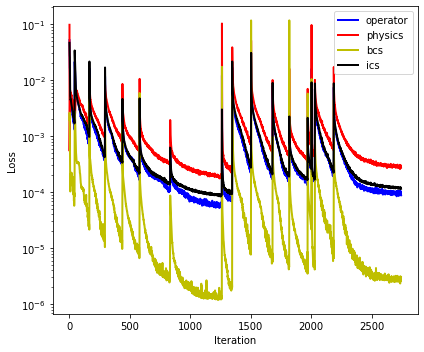

In [14]:
plt.figure(figsize = (6,5))
plt.plot(model.loss_operator_log, 'b-', lw=2, label='operator')
plt.plot(model.loss_physics_log, 'r-', lw=2, label='physics')
plt.plot(model.loss_bcs_log, 'y-', lw=2, label='bcs')
plt.plot(model.loss_ics_log, 'k-', lw=2, label='ics')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Test on Single Sample

In [20]:
# Generate a Single Test Data
key = 23
s_test_ = S_test[key]
# key = random.PRNGKey(112312347)
# P_test = 100
Nx = m
Nt = 101
u_test, y_test, s_test = generate_one_test_data(key, s_test_, Nx, Nt)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = jnp.linspace(0, 1, Nx)
t = jnp.linspace(0, 1, Nt)
XX, TT = jnp.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_true = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')
# S_true = s_test_


# compute_error(key, )
# # Compute the relative l2 ermor 
# error = jnp.linalg.norm(S_pred - S_true, 2) / jnp.linalg.norm(S_true, 2) 
# print('Relative l2 errpr: {:.3e}'.format(error))

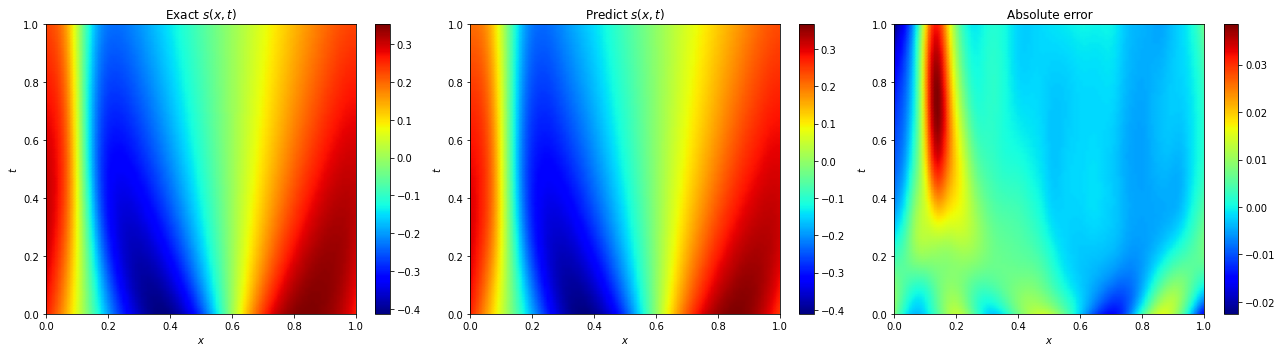

In [21]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(XX,TT, S_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_pred - S_true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()